In [3]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm
import seaborn.apionly as sns

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

### Montecarlo . Calculating PI

In one of the circle cuadrants the area of the semicirle is given by:

$\frac{1}{4} \pi r^2$

and the area of the square is given by:

$r^2$

Therefore the ratio = $\pi /4$


A Monte Carlo method for determining $\pi$ using this knowledge works by

  - Drawing a set of random points from inside the unit square

  - Counting the number of points that fall inside the quarter of the unit circle

  - Calculating the ratio of the number of points inside the quarter of the unit circle to the total number of points, which approaches $\pi/4$ as the number of random points increases.
  
  


In [14]:
#Pi animation
Image(url='graphics/Pi_30K.gif')

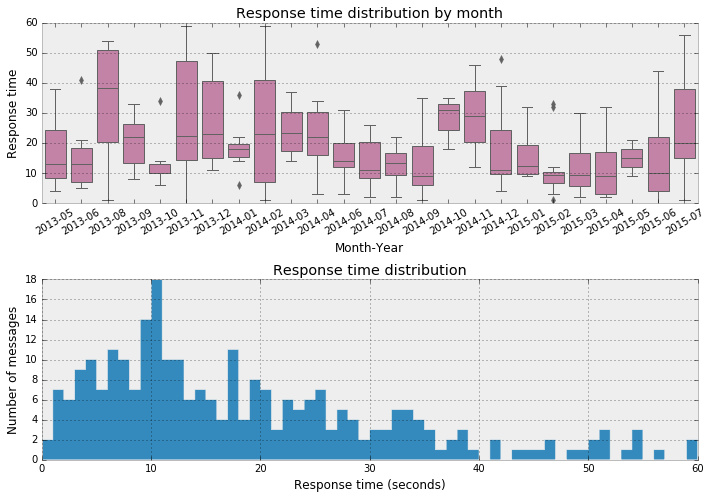

In [4]:
#what does the data look like?
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(211)

order = np.sort(messages['year_month'].unique())
sns.boxplot(x=messages['year_month'], y=messages['time_delay_seconds'], order=order, orient="v", color=colors[5], linewidth=1, ax=ax)
_ = ax.set_title('Response time distribution by month')
_ = ax.set_xlabel('Month-Year')
_ = ax.set_ylabel('Response time')
_ = plt.xticks(rotation=30)

ax = fig.add_subplot(212)
plt.hist(messages['time_delay_seconds'].values, range=[0, 60], bins=60, histtype='stepfilled', color=colors[0])
_ = ax.set_title('Response time distribution')
_ = ax.set_xlabel('Response time (seconds)')
_ = ax.set_ylabel('Number of messages')

plt.tight_layout()

In [5]:
messages.head()

,conversation_id,event_id,timestamp,sender,message_length,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
0,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 03:44:12,Mark Regan,14,3,TEXT,2014-08-15 03:44:00,John,12.0,1.0,4,2014-08,0
1,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1JJEmE5K,2013-12-19 02:49:28,Mark Regan,44,2,TEXT,2013-12-19 02:48:50,Peter,38.0,1.0,3,2013-12,0
2,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1NQV6lMv,2013-12-19 02:50:02,Mark Regan,29,2,TEXT,2013-12-19 02:49:50,Peter,12.0,1.0,3,2013-12,0
3,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1RPd1OTh,2013-12-19 02:50:34,Mark Regan,102,2,TEXT,2013-12-19 02:50:11,Peter,23.0,1.0,3,2013-12,0
4,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1XZ3YFlF,2013-12-19 02:51:25,Mark Regan,15,2,TEXT,2013-12-19 02:51:14,Peter,11.0,1.0,3,2013-12,0


### How do Bayesians think about data?

From a Bayesian's perspective, data is generated by a random process. However, now that the data is observed, it is fixed and does not change. This random process has some model parameters that are fixed. However, the Bayesian uses probability distributions to represent his/her uncertainty in these parameters.

In the previous section we imported Mark Regan's chat dataset. We are interested in the time it takes me to respond to messages (`response_time`). Given that `response_time` is count data, we can model it as a Poisson distribution and estimate its parameter $\mu$.

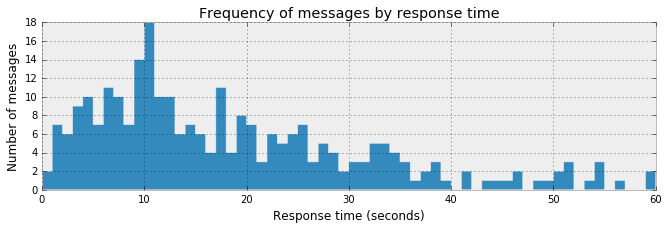

In [6]:
fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, 
             range=[0, 60], bins=60, histtype='stepfilled')

### Bayesian method of estimating $\mu$
 
$$\overbrace{p(\mu \ |\ Data)}^{\text{posterior}} = \dfrac{\overbrace{p(Data \ | \ \mu)}^{\text{likelihood}} \cdot \overbrace{p(\mu)}^{\text{prior}}}{\underbrace{p(Data)}_{\text{marginal likelihood}}}$$

The above schema can be interpreted as follows (from the bottom up):
- We observe counts of data (y) for each conversation i (Observed Data)
- This data was generated by a random process which we believe can be represented as a Poisson distribution (Likelihood)
- This Poisson distribution has a single parameter $\mu$ which we know is between 0 and 60 (Prior)
  - We will model $\mu$ as a uniform distribution because we do not have an opinion as to where within this range to expect it

### The magical mechanics of MCMC

The MCMC sampler draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values. 

$$\overbrace{p(\mu \ |\ Data)}^{posterior} \varpropto \overbrace{p(Data \ | \ \mu)}^{likelihood} \cdot \overbrace{p(\mu)}^{prior}$$

This calculation acts as a guiding light for the MCMC sampler. As it draws values from the paramater priors, it computes the likelihood of these paramters given the data - and will try to guide the sampler towards areas of higher probability.

The Bayesian method is concerned with traversing and collect samples around the area of highest probability. All of the samples collected are considered to be a credible parameter.

In [8]:
Image(url='graphics/mcmc-animate.gif')

In [7]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

100%|██████████| 200000/200000 [00:37<00:00, 5347.52it/s]


The above code has just gathered 200,000 credible samples of $\mu$ by traversing over the areas of high likelihood of the posterior distribution of $\mu$. The below plot (left) shows the distribution of values collected for $\mu$. The mean of this distribution is almost identical to the frequentist estimate (red line). However, we also get a measure of uncertainty and can see that there are credible values of $\mu$ between 17 and 19. This measure of uncertainty is incredibly valuable as we will see later.

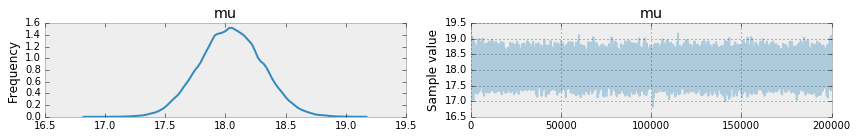

In [10]:
_ = pm.traceplot(trace, varnames=['mu'])

### Discarding early samples (burnin)
You may have wondered what the purpose of `pm.find_MAP()` is in the above MCMC code. MAP stands for maximum a posteriori estimation. It helps the MCMC sampler find a good place from which to start sampling. Ideally this will start the model off in an area of high likelihood - but sometimes that doesn't happen. As a result, the samples collected early in the trace (burnin samples) are often discarded.

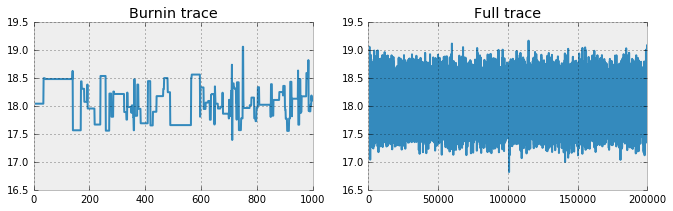

In [11]:
fig = plt.figure(figsize=(11,3))
plt.subplot(121)
_ = plt.title('Burnin trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('mu')[:1000])
fig = plt.subplot(122)
_ = plt.title('Full trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('mu'))

### Model convergence
#### Trace
Just because the above model estimated a value for $\mu$, doesn't mean the model estimated a good value given the data. There are some recommended checks that you can make. Firstly, look at the trace output. You should see the trace jumping around and generally looking like a hairy caterpillar. If you see the trace snake up and down or appear to be stuck in any one location - it is a sign that you have convergence issues and the estimations from the MCMC sampler cannot be trusted.

#### Autocorrelation plot
The second test you can perform is the autocorrelation test (see below plot). It is a measure of correlation between successive samples in the MCMC sampling chain. When samples have low correlation with each other, they are adding more "information" to the estimate of your parameter value than samples that are highly correlated.

Visually, you are looking for an autocorrelation plot that tapers off to zero relatively quickly and then oscilates above and below zero correlation. If your autocorrelation plot does not taper off - it is generally a sign of poor mixing and you should revisit your model selection (eg. likelihood) and sampling methods (eg. Metropolis).

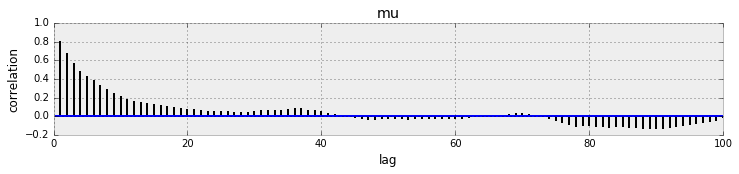

In [12]:
_ = pm.autocorrplot(trace[:2000], varnames=['mu'])

### References
- [MCMC animation by Maxwell Joeseph](http://blog.revolutionanalytics.com/2013/09/an-animated-peek-into-the-workings-of-Bayesian-statistics.html)

In [13]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()